### Importing libraries and packages

In [1]:
import numpy as np
import pandas as pd

import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing, metrics

from tensorflow.keras import models, layers, preprocessing as kprocessing
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

import arabic_reshaper
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bidi.algorithm import get_display
from sklearn import manifold
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Importing dataset

In [2]:
#non-cleaned datasets 
data19 = pd.read_csv("2019-01_sample.csv") #2019 original
data20 = pd.read_csv("2020-01_sample.csv") #2020 original

#cleaned datasets (preprocessed)
data19_clean = pd.read_csv("clean_data_2019.csv") 
data20_clean = pd.read_csv("clean_data_2020.csv")

In [3]:
print(data19["is_spam"].value_counts(),"\n") #a lot of tweets are recognized as non spam (only 54/1000 are spam)
print(data20["is_spam"].value_counts()) #non spam is still more than spam but better than the older dataset

N    946
Y     54
Name: is_spam, dtype: int64 

N    620
Y    380
Name: is_spam, dtype: int64


### splitting the dataset into training and testing sets

In [4]:
x_train, x_test, y_train, y_test = split(data20_clean["body"],data20_clean["is_spam"], 
                                         test_size = 0.2, random_state = 10)

### Creating word embeddings

<b> creating word embeddings using Word2Vec by transforming the corpus (tweets) into a list of words then using it inside the Word2Vec model from genism library </b>

In [5]:
# for (training set)
corpus20_clean = x_train

#Splitting sentences to list of words 
word_in_corpus = []
for sentence in corpus20_clean: word_in_corpus.append(str(sentence).split())

#Creating the Word2Vec embedding
word2vec = Word2Vec(word_in_corpus, size = 300, window = 8, min_count = 3, sg = 1, iter=45)

#Testig the embedding using the similarity function
word2vec.wv.most_similar("تخفيض")

[('هين', 0.9951160550117493),
 ('قسيمه', 0.9947423934936523),
 ('رهيب', 0.989325761795044),
 ('استخدم', 0.9870523810386658),
 ('ايهيرب', 0.9835159182548523),
 ('الكود', 0.9831433296203613),
 ('سنت', 0.9780594110488892),
 ('قولدن', 0.977688729763031),
 ('يخصم', 0.9627789258956909),
 ('اوناس', 0.9625658988952637)]

<b> Visualizing word embeddings </b>

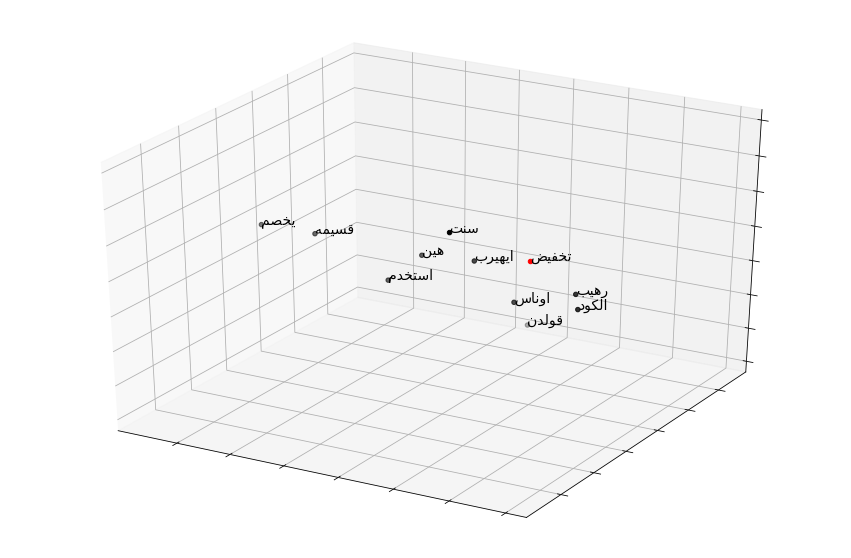

In [6]:
#Visualizing Word2Vec embeddings

word = "تخفيض" #(word example)

fig = plt.figure(figsize=(15,10))

tot_words = [word] + [tupla[0] for tupla in word2vec.wv.most_similar(word, topn=10)]
X = word2vec.wv[tot_words]

pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_.iloc[0:1, dtf_.columns.get_loc('input')] = 1



ax = fig.add_subplot(111,projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])


for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=get_display(arabic_reshaper.reshape(label)),fontsize=14)

In [7]:
#using keras tokenizer
tokenizer = kprocessing.text.Tokenizer(split=' ')

#fitting tokenizer
tokenizer.fit_on_texts(word_in_corpus)

#creating dictionary of vocabulary
dictionary = tokenizer.word_index

#creating a list of sequences for each word
text_sequence = tokenizer.texts_to_sequences(word_in_corpus)

#creating paddings from sequnces to use in the neural network
x_train = kprocessing.sequence.pad_sequences(text_sequence, maxlen=60, padding="post", truncating="post")

# doing the same steps for the testing set

corpus20_clean = x_test

word_in_corpus = []
for sentence in corpus20_clean: word_in_corpus.append(str(sentence).split())

text_sequence = tokenizer.texts_to_sequences(word_in_corpus)

x_test = kprocessing.sequence.pad_sequences(text_sequence, maxlen=60, padding="post", truncating="post")

array([[   5, 2116,    1, ...,    0,    0,    0],
       [2121,   22, 2122, ...,    0,    0,    0],
       [2134,  656,    1, ...,    0,    0,    0],
       ...,
       [1992,    5, 1429, ...,    0,    0,    0],
       [8680, 8681,  248, ...,    0,    0,    0],
       [8698, 8699,  303, ...,    0,    0,    0]], dtype=int32)

In [8]:
#testing on a logstic regression model 
LRModel = LogisticRegression()
LRModel.fit(x_train,y_train)
LRprediction = LRModel.predict(x_test)
print(classification_report(y_test, LRprediction))

              precision    recall  f1-score   support

           0       0.61      0.84      0.71       122
           1       0.41      0.17      0.24        78

    accuracy                           0.58       200
   macro avg       0.51      0.51      0.47       200
weighted avg       0.53      0.58      0.53       200



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [9]:
#testing on a logstic regression model - increasing iterations
LRModel = LogisticRegression(max_iter = 1000)
LRModel.fit(x_train,y_train)
LRprediction = LRModel.predict(x_test)
print(classification_report(y_test, LRprediction))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       122
           1       0.43      0.33      0.37        78

    accuracy                           0.56       200
   macro avg       0.53      0.52      0.52       200
weighted avg       0.55      0.56      0.55       200



In [10]:
#tried over sampling then using the oversampled training sets in a linear regression

#oversample = SMOTE(sampling_strategy ='all',random_state=42)
#x_train, y_train = oversample.fit_resample(x_train, y_train)

In [11]:
#LRModel = LogisticRegression(max_iter = 2500)
#LRModel.fit(x_train,y_train)
#LRprediction = LRModel.predict(x_test)
#print(classification_report(y_test, LRprediction))

In [12]:
#creating embeddings for the neural network (weights)

embeddings = np.zeros((len(dictionary)+1, 300))

for word, index in dictionary.items():
    try:
        embeddings[index] = word2vec.wv[word] 
    except:
        pass
    break
print(embeddings.shape)

(8701, 300)


In [13]:
#checking the shape of the input
x_train.shape

(800, 60)

In [14]:
#creating a neural network model (embedding layer, input layer, dense layer, output layer)
model = models.Sequential([
    
        layers.Embedding(input_dim = embeddings.shape[0],
                    output_dim = embeddings.shape[1],
                    weights = [embeddings],
                    input_length = 60, trainable=False),
    
    layers.Input(shape= (60,)),
    

        
    
    layers.Dense(120, activation="relu"),
    
    layers.Dense(1,activation = "softmax")  
]) 

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 300)           2610300   
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
dense (Dense)                (None, 60, 120)           36120     
_________________________________________________________________
dense_1 (Dense)              (None, 60, 1)             121       
Total params: 2,646,541
Trainable params: 36,241
Non-trainable params: 2,610,300
_________________________________________________________________


In [15]:
training = model.fit(x=x_train, y=y_train, batch_size=100, 
                     epochs=1000, shuffle=False, verbose=0, 
                     validation_split=0.3)

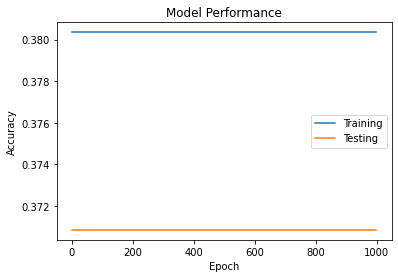

In [16]:
plt.plot(training.history[ 'accuracy' ])
plt.plot(training.history[ 'val_accuracy' ])
plt.title( 'Model Performance' )
plt.ylabel( 'Accuracy' )
plt.xlabel( 'Epoch' )
plt.legend([ 'Training' , 'Testing' ])
plt.show()

In [17]:
predicted_prob = model.predict(x_test)
predicted = [y_train[np.argmax(pred)] for pred in predicted_prob]

classes = np.unique(y_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.39      1.00      0.56        78

    accuracy                           0.39       200
   macro avg       0.20      0.50      0.28       200
weighted avg       0.15      0.39      0.22       200



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#creating a neural network model (embedding layer, input layer, 2 dense layers, output layer)

model = models.Sequential([
    
    layers.Embedding(input_dim = embeddings.shape[0],
                    output_dim = embeddings.shape[1],
                    weights = [embeddings],
                    input_length = 60, trainable=False), 
    
  layers.Dense(units=64, activation='relu', input_shape=(60,)),
  layers.Dropout(rate=0.2),
    
  layers.Dense(units=32, activation='relu'),
  layers.Dropout(rate=0.2),
    
  layers.Dense(units=16, activation='relu'),
  layers.Dense(units=1, activation='linear'),
])

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 300)           2610300   
_________________________________________________________________
dense_2 (Dense)              (None, 60, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 60, 32)            2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 60, 16)            528       
_________________________________________________________________
dense_5 (Dense)              (None, 60, 1)            

In [19]:
training = model.fit(x=x_train, y=y_train, batch_size=50, 
                     epochs=1000, shuffle=False, verbose=0, 
                     validation_split=0.3)

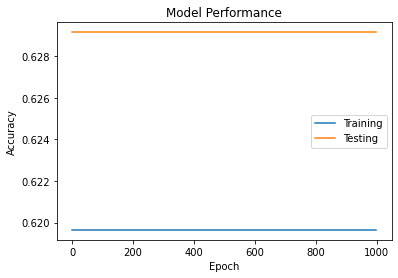

In [20]:
plt.plot(training.history[ 'accuracy' ])
plt.plot(training.history[ 'val_accuracy' ])
plt.title( 'Model Performance' )
plt.ylabel( 'Accuracy' )
plt.xlabel( 'Epoch' )
plt.legend([ 'Training' , 'Testing' ])
plt.show()

In [21]:
#creating a neural network model (embedding layer, input layer, 2 dense layers, output layer) (changed metric in compiling only)

model = models.Sequential([
    
    layers.Embedding(input_dim = embeddings.shape[0],
                    output_dim = embeddings.shape[1],
                    weights = [embeddings],
                    input_length = 60, trainable=False), 
    
  layers.Dense(units=64, activation='relu', input_shape=(60,)),
  layers.Dropout(rate=0.2),
    
  layers.Dense(units=32, activation='relu'),
  layers.Dropout(rate=0.2),
    
  layers.Dense(units=16, activation='relu'),
  layers.Dense(units=1, activation='linear'),
])

model.compile(
  loss="mse",
  optimizer="adam",
  metrics=['mse']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 300)           2610300   
_________________________________________________________________
dense_6 (Dense)              (None, 60, 64)            19264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 60, 32)            2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 60, 16)            528       
_________________________________________________________________
dense_9 (Dense)              (None, 60, 1)            

In [22]:
training = model.fit(x=x_train, y=y_train, batch_size=50, 
                     epochs=1000, shuffle=False, verbose=0, 
                     validation_split=0.3)

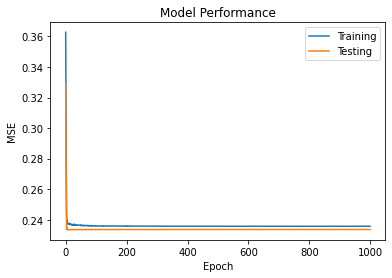

In [23]:
plt.plot(training.history[ 'mse' ])
plt.plot(training.history[ 'val_mse' ])
plt.title( 'Model Performance' )
plt.ylabel( 'MSE' )
plt.xlabel( 'Epoch' )
plt.legend([ 'Training' , 'Testing' ])
plt.show()

In [24]:
training.history[ 'mse' ][999]

0.23574408888816833

In [25]:
#creating a neural network model (embedding layer, input layer, 3 dense layers, output layer) 

model = models.Sequential([
    
    layers.Embedding(input_dim = embeddings.shape[0],
                    output_dim = embeddings.shape[1],
                    weights = [embeddings],
                    input_length = 60, trainable=False), 
    
  layers.Dense(units=64, activation='relu', input_shape=(60,)),
  layers.Dropout(rate=0.2),
    
  layers.Dense(units=32, activation='relu'),
  layers.Dropout(rate=0.2),
    
     
  layers.Dense(units=16, activation='relu'),
  layers.Dropout(rate=0.2),

  layers.Dense(units=8, activation='relu'),
  layers.Dense(units=1, activation='linear'),
])

model.compile(
  loss="mse",
  optimizer="adam",
  metrics=['mse']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 300)           2610300   
_________________________________________________________________
dense_10 (Dense)             (None, 60, 64)            19264     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 60, 32)            2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 60, 16)            528       
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 16)           

In [26]:
training = model.fit(x=x_train, y=y_train, batch_size=100, 
                     epochs=1000, shuffle=True, verbose=0, 
                     validation_split=0.3)

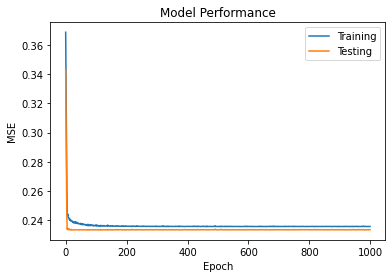

In [27]:
plt.plot(training.history[ 'mse' ])
plt.plot(training.history[ 'val_mse' ])
plt.title( 'Model Performance' )
plt.ylabel( 'MSE' )
plt.xlabel( 'Epoch' )
plt.legend([ 'Training' , 'Testing' ])
plt.show()

In [28]:
training.history[ 'mse' ][999]

0.23569448292255402